In [1]:
# This notebook revolves around search exploration for 
# a corpus of Marvel scripts at the back end. We specifically,
# consume the BM-25 algorithm which uses a slightly different 
# version of the TF-IDF which was proven to be extremely
# efficient for search indexing.

# Install the pdf to image package
# ! pip3 install pdf2image
# ! /opt/homebrew/bin/brew install poppler
# from tensorflow.python.compiler.mlcompute import mlcompute

In [9]:
import os
from os import listdir
from pdf2image import convert_from_path

scripts_path = '/Users/rajyalakshmigollakota/Downloads/marvel_scripts/'
pdfs = listdir(scripts_path)

for pdf in pdfs:
    if 'pdf' not in pdf:
        continue
    pages = convert_from_path(scripts_path + pdf, 350, poppler_path='/opt/homebrew/Cellar/poppler/21.11.0/bin/')
    pdf_dir = pdf.split('.')[0]
    if os.path.isdir(pdf_dir):
        continue
    os.mkdir(pdf_dir)
    page_num = 1
    for page in pages:
        image_name = "%s/Page_" % pdf_dir + str(page_num) + ".jpg"  
        page.save(image_name, "JPEG")
        page_num += 1

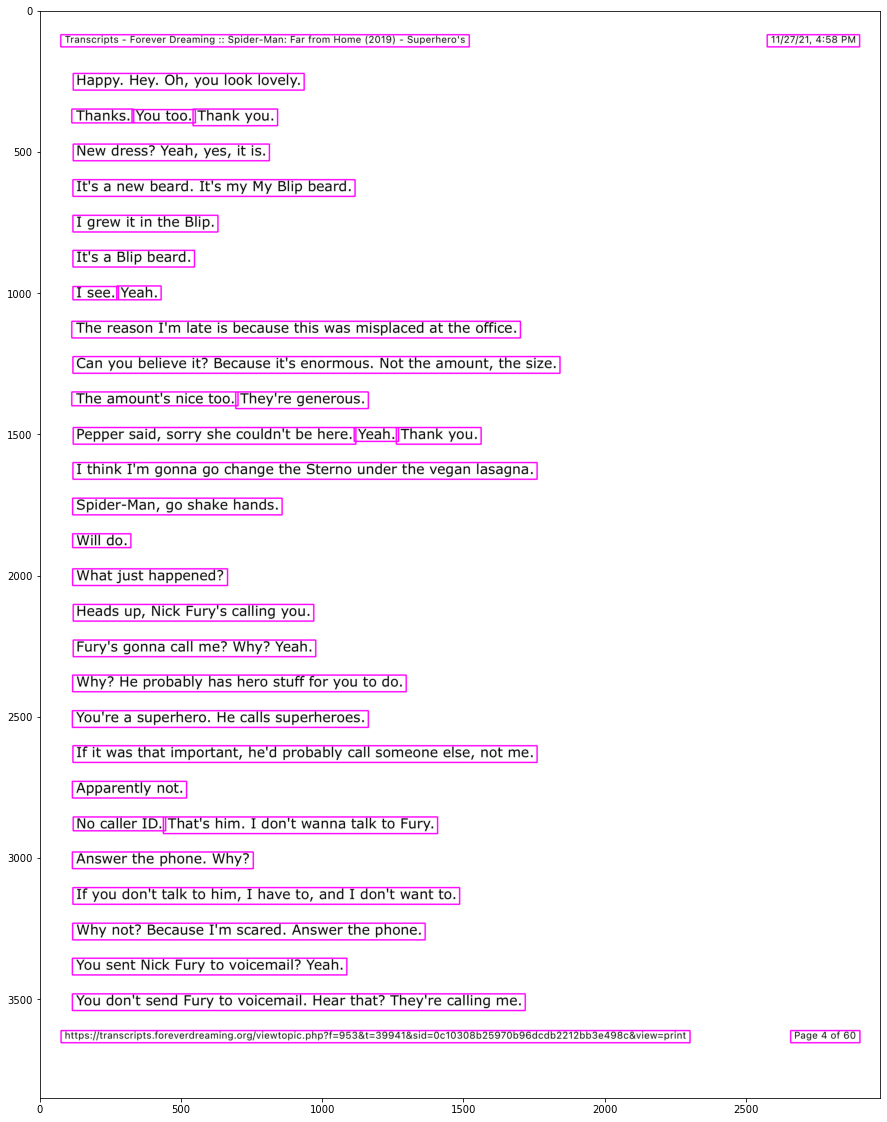

In [10]:
# ! pip3 install opencv-python
# ! pip3 install Pillow
import cv2
import matplotlib.pyplot as plt

def mark_region(image_path):
    
    image = cv2.imread(image_path)

    # define threshold of regions to ignore
    THRESHOLD_REGION_IGNORE = 40

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,4))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        if w < THRESHOLD_REGION_IGNORE or h < THRESHOLD_REGION_IGNORE:
            continue
        
        image = cv2.rectangle(image, (x,y), (x+w, y+h), color=(255,0,255), thickness=3)
        line_items_coordinates.append([(x,y), (x+w, y+h)])

    return image, line_items_coordinates

# Print a page to see if the shape sampling is performing well
FILENAME = pdf_dir + '/Page_4.jpg'

image, line_items_coordinates = mark_region(FILENAME)
plt.figure(figsize=(20,20))
plt.imshow(image)

In [11]:
# pytesseract is an optical character recognition tool in Python
# ! pip3 install pytesseract
import pytesseract

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'

# load the original image
image = cv2.imread(pdf_dir + '/Page_4.jpg')
page_text = ''

for line in line_items_coordinates:
    # get co-ordinates to crop the image
    c = line

    # cropping image img = image[y0:y1, x0:x1]
    img = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]    

    # plt.figure(figsize=(10,10))
    # plt.imshow(img)

    # convert the image to black and white for better OCR
    ret,thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)

    # pytesseract image to string to get results
    text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
    page_text += ' ' + text.strip()

In [23]:
#! pip3 install nltk
import nltk 
# nltk.download('stopwords')
from nltk.corpus import stopwords

def process_text(raw_text, _reverse=True):
    '''
    Simple function to reverse a text. Convert to a 
    list and then reverse + join it back
    '''
    _list = raw_text.split()
    if _reverse:
        _list.reverse()
    stop_words = stopwords.words('english')
    _list = [_word for _word in _list if _word.lower() not in stop_words]
    step_final_text = ' '.join(_list)
    return step_final_text

print(process_text(page_text))

In [13]:
# Use the textract pkg to parse through .doc/.docx files
#! pip3 install textract

# Use the PyPDF2 pkg to parse through .pdf
#! pip3 install PyPDF2

In [14]:
# Text-mining
# Open text, .doc, .pdf documents and form a Dataframe with format:
# +--------------+-------------------------+
# | Movie        |      Script             |
# +--------------+-------------------------+
# | spider-man-2 |    <processed script>   |
# | spider-man-4 |    <processed script>   |
# | hulk         |    <processed script>   |
# | .            |                         | 
# | .            |                         | 
# +----------------------------------------+
import pandas
import textract
import pytesseract

df_movies = pandas.DataFrame(columns=['Movie', 'Script'])
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'

for pdf in pdfs:
    _dir = pdf.split('.')[0]
    try:
        if 'pdf' in pdf:
            page_text = ''
            
            # Read pages from disk
            for page in os.listdir('%s/' % _dir):
                print('Extracting text from script/page: %s/%s' %(_dir, page))
                
                # load the original image
                image = cv2.imread('%s/%s' % (_dir, page))
                 
                _, line_items_coordinates = mark_region('%s/%s' % (_dir, page))

                for line in line_items_coordinates:
                    # get co-ordinates to crop the image
                    c = line
                    # cropping image img = image[y0:y1, x0:x1]
                    img = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]    
                    
                    # convert the image to black and white for better OCR
                    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        
                    # pytesseract image to string to get results
                    text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
        
                    page_text += ' ' + process_text(text).strip()    
            # print(page_text) 
            # break
            
    except UnicodeDecodeError:
        continue
        print('Trying the textract for file %s' % _file)
        data = textract.process(base_path + _file)   
    row = {'Movie': pdf, 'Script': page_text}
    df_movies = df_movies.append(row, ignore_index = True)

Extracting text from script/page: spider-man-4/Page_2.jpg
Extracting text from script/page: spider-man-4/Page_3.jpg
Extracting text from script/page: spider-man-4/Page_1.jpg
Extracting text from script/page: spider-man-4/Page_40.jpg
Extracting text from script/page: spider-man-4/Page_4.jpg
Extracting text from script/page: spider-man-4/Page_5.jpg
Extracting text from script/page: spider-man-4/Page_41.jpg
Extracting text from script/page: spider-man-4/Page_7.jpg
Extracting text from script/page: spider-man-4/Page_6.jpg
Extracting text from script/page: spider-man-4/Page_19.jpg
Extracting text from script/page: spider-man-4/Page_31.jpg
Extracting text from script/page: spider-man-4/Page_25.jpg
Extracting text from script/page: spider-man-4/Page_24.jpg
Extracting text from script/page: spider-man-4/Page_30.jpg
Extracting text from script/page: spider-man-4/Page_18.jpg
Extracting text from script/page: spider-man-4/Page_26.jpg
Extracting text from script/page: spider-man-4/Page_32.jpg
Extr

In [39]:
df_movies.head()

,Movie,Script
0,spider-man-4.pdf,(CONTINUED) Co another. building swing cost...
1,.DS_Store,(CONTINUED) Co another. building swing cost...
2,spider-man-2.pdf,him. know find might feel seemed MAY (...
3,incredible-hulk.pdf,event. ) (MORE suppressed ust maybe we've ev...
4,spider-man-2002.pdf,"Ww, 1 @ , - enone -_~ 7. ny ~ _ Lo bank those..."


In [74]:
# Write the data-frame to disk (to pkl) since it takes time 
# to process the raw files & convert to text.

# NOTE:
# Writing to csv can be challenging since, the columns can get 
# shuffled & cause the export/import to cause variations 
# in data. Easier to instead pkl the data using df.to_pickle() 
# to save the dataframe from memory and df.read_pickle() to read 
# it back
df_movies.to_pickle('movies.pkl')

In [2]:
import pandas
df_movies_pkl= pandas.read_pickle('movies.pkl')
df_movies_pkl.head()

,Movie,Script
0,spider-man-4.pdf,(CONTINUED) Co another. building swing cost...
1,.DS_Store,(CONTINUED) Co another. building swing cost...
2,spider-man-2.pdf,him. know find might feel seemed MAY (...
3,incredible-hulk.pdf,event. ) (MORE suppressed ust maybe we've ev...
4,spider-man-2002.pdf,"Ww, 1 @ , - enone -_~ 7. ny ~ _ Lo bank those..."


In [24]:
# ! pip3 install rank_bm25
# ! pip3 install tqdm
# ! pip3 install spacy
# Also, the better way to install these modules is to do it
# from the Anaconda-navigator > Environment > Launch Terminal

import spacy
from tqdm import tqdm
import rank_bm
from rank_bm25 import BM25Okapi


# Let's do a search using BM-25
query = 'With great power comes great responsibility'

# Remove stopwords
proc_query = process_text(query, _reverse=False)

nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus

# Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(df_movies_pkl.Script.str.lower().values, 
                         disable=["tagger", "parser", "ner"])):
    tok = [t.text for t in doc if t.is_alpha]
    tok_text.append(tok)


0it [00:00, ?it/s]
3it [00:00, 18.48it/s]
6it [00:00,  9.07it/s]


In [41]:
import re

bm25 = BM25Okapi(tok_text)

tokenized_query = proc_query.lower().split(" ")
import time

print('Final query: %s' % proc_query)

# Retrieve most relevent movie to query
scores = bm25.get_scores(tokenized_query)
max_score_index = list(scores).index(max(scores))

movie = re.sub(r'\..*$', '', df_movies_pkl.iloc[max_score_index][0])

print('Most relevant movie to query: %s' % movie)

Final query: great power comes great responsibility
Most relevant movie to query: spider-man-2


In [43]:
# Retrieve search like index - Top N documents that match 
# the quote

start_time = time.time()
results = bm25.get_top_n(tokenized_query, df_movies_pkl.Script.values, n=3)
end_time = time.time()

print('Searching %d scripts took %s seconds' %(len(scores), (end_time-start_time)))

for i in results:
      print(i)

Searching 6 scripts took 0.006914615631103516 seconds
 him.    know  find might   feel seemed  MAY (CONT'D)   Boston  him. looking pie.  fiddling  Man. Spider     looking said MAY   you? Why? PETER spoon  stops  Freaked mouth. halfway  this.  today. you.  looking   Barlier Octopus. awful  know, MAY Days  ate.  front  in. right digs him. soup | since 7S puts May Aunt  Peter  bowl table    sits NIGHT KITCHEN INT. Soup.   downstairs reter, Come Peter, well. look  you, dear. long, worried I'm . 1   heard    (beat) must   right.   running, still trains T£  running. still trains MAY  there? happening  news? know what's   May, Aunt   PETER Boston  pie. MAY soup?  way  here--   PETER whipped Boston Real pie.  soup, favorite, maae  made  Here, Well,  MAY this--snug. (CONT'D) .Y 90. back,  Jameson Snatches gr: Harry crumples   grabs fist.    wincing. -, finger know really  they're    know * campaign doing. : people public go   leave  home, running JJJ (CONT'D) Harry. Jameson   Jabs finger strang